# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * rnn for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [3]:
low_RAM_mode = False
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [32]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t')
 

In [33]:
print(df.shape, df.is_blocked.mean())
df[:5]

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43


![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

In [34]:
print("Blocked ratio",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio 0.228222107326
Count: 1204949


# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [35]:
#downsample


# < downsample data so that both classes have approximately equal ratios>
legal_indices = df[df['is_blocked'] == 0].index
illegal_indices = df[df['is_blocked'] == 1].index
chosen_legal_indices = np.random.choice(legal_indices, 250000)
chosen_illegal_indices = np.random.choice(illegal_indices, 250000)
df = pd.concat([df.iloc[chosen_illegal_indices], df.iloc[chosen_legal_indices]])


print("Blocked ratio:",df.is_blocked.mean())
print("Count:",len(df))

Blocked ratio: 0.5
Count: 500000


In [36]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print("All tests passed")

All tests passed


In [38]:
#In case your RAM-o-meter is in the red
if very_low_RAM:
    data = data[::2]

# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [51]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1


### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

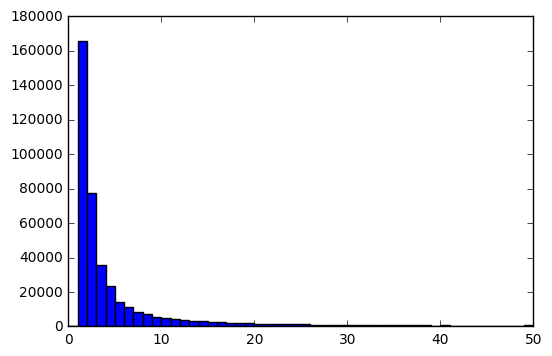

In [52]:
#Word frequency distribution, just for kicks
_=plt.hist(list(token_counts.values()),range=[0,50],bins=50)

In [53]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10
tokens = [token for token, count in token_counts.items() if count >= min_count]

In [54]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0


In [55]:
print("# Tokens:",len(token_to_id))
if len(token_to_id) < 30000:
    print("Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc")
if len(token_to_id) > 1000000:
    print("Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc")

# Tokens: 84388


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [60]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.lower()
        tokens = tokenizer.tokenize(s)
        token_ids = list(map(lambda token: token_to_id.get(token,0), tokens))[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [61]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Data format examples


In [62]:
print("Размер матрицы:",title_tokens.shape)
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print(title,'->', tokens[:10],'...')

Размер матрицы: (500000, 15)
Продам кальян новый 70 см -> [ 4977 56187  3004 28005 55136     0     0     0     0     0] ...
Жир медвежий -> [45581  4748     0     0     0     0     0     0     0     0] ...
Математика алгебра геометрия для школьников и студ -> [39621 34978 30897 59617 63914 81303 64773     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [63]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]


In [67]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

categories = [{"category":category, "subcategory":subcategory} for category, subcategory in data_cat_subcat]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [68]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

# Split data into training and test

In [69]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [70]:
#Split into training and test set.
from sklearn.cross_validation import train_test_split

#Difficulty selector:
#Easy: split randomly
#Medium: select test set items that have item_ids strictly above that of training set
#Hard: do whatever you want, but score yourself using kaggle private leaderboard

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(title_tokens, desc_tokens, df_non_text, target, test_size=0.3)

## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [ ]:
save_prepared_data = True #save
read_prepared_data = False #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print("Saving preprocessed data (may take up to 3 minutes)")

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print("готово")
    
elif read_prepared_data:
    print("Reading saved data...")
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print("done")       

# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [74]:
#libraries
import lasagne
from theano import tensor as T
import theano

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


In [93]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# NN architecture

In [94]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [95]:
# Descriptions

#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_nn = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=512)
descr_nn = lasagne.layers.LSTMLayer(descr_nn, num_units=512)
descr_nn = lasagne.layers.LSTMLayer(descr_nn, num_units=512)
descr_nn = lasagne.layers.LSTMLayer(descr_nn, num_units=512)
descr_nn = lasagne.layers.flatten(descr_nn)

# Titles
title_nn = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id) + 1, output_size=64)
title_nn = lasagne.layers.LSTMLayer(title_nn, num_units=128)
title_nn = lasagne.layers.LSTMLayer(title_nn, num_units=128)
title_nn = lasagne.layers.LSTMLayer(title_nn, num_units=128)
title_nn = lasagne.layers.flatten(title_nn)
# Non-sequences
cat_nn = lasagne.layers.DenseLayer(cat_inp, 128)

In [96]:
nn = lasagne.layers.concat([descr_nn, title_nn, cat_nn])                                 
nn = lasagne.layers.DenseLayer(nn, 512)
nn = lasagne.layers.DropoutLayer(nn,p=0.5)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [97]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [98]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y,delta = 1).mean()

In [99]:
#Weight optimization step
updates = lasagne.updates.adam(loss, weights)

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

In [100]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
det_loss = lasagne.objectives.binary_hinge_loss(det_prediction,target_y,delta = 1).mean()

### Coffee-lation

In [101]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates)
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction])

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [102]:
#average precision at K

from oracle import APatK, score

In [103]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 100
batch_size = 100
minibatches_per_epoch = 100
# nontext_tr = nontext_tr.values

for i in range(n_epochs):
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("Train:")
    print('\tloss:',b_loss/b_c)
    print('\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_tr,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("Val:")
    print('\tloss:',b_loss/b_c)
    print('\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))

Train:
	loss: 8540.0366757
	acc: 0.636534653465
	auc: 0.645811845241
	ap@k: 0.0903227436192
Val:
	loss: 2306.04049241
	acc: 0.709603960396
	auc: 0.691912327262
	ap@k: 0.932825674204
Train:
	loss: 2007.87977994
	acc: 0.738910891089
	auc: 0.749239378462
	ap@k: 0.0964250603546
Val:
	loss: 10144.404946
	acc: 0.747425742574
	auc: 0.733868354724
	ap@k: 0.875326729113
Train:
	loss: 1899.49950954
	acc: 0.768415841584
	auc: 0.813682494147
	ap@k: 0.120238125635
Val:
	loss: 6825.97466328
	acc: 0.766138613861
	auc: 0.730978099013
	ap@k: 0.401202734582
Train:
	loss: 2793.43059289
	acc: 0.793663366337
	auc: 0.834971706232
	ap@k: 0.143937270894
Val:
	loss: 603.037255793
	acc: 0.814455445545
	auc: 0.838447264475
	ap@k: 0.612287510411
Train:
	loss: 2112.80781006
	acc: 0.797227722772
	auc: 0.813854343176
	ap@k: 0.0696820427547
Val:
	loss: 3215.00392208
	acc: 0.787722772277
	auc: 0.789808107578
	ap@k: 0.47033849359
Train:
	loss: 1078.73414999
	acc: 0.784554455446
	auc: 0.835080951519
	ap@k: 0.24928842564

In [ ]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

# Final evaluation
Evaluate network over the entire test set

In [108]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
nontext_ts = nontext_ts.values
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print("Scores:")
print('\tloss:',b_loss/b_c)
print('\tacc:',final_accuracy)
print('\tauc:',final_auc)
print('\tap@k:',final_apatk)
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.135597576343
	acc: 0.94304
	auc: 0.969264801565
	ap@k: 0.945693603199

AUC:
	Сойдёт, хотя можно ещё поднажать (ok)

Accuracy:
	Всё ок (ok)

Average precision at K:
	Вы побили baseline (ok)


# Main task

* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92

* Remember the training, Luke
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.